In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.backends.cudnn
torch.backends.cudnn.benchmark = True

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
num_train = 49000
num_val = 1000
batch_size = 256
hidden_dim = 512
learning_rate = 0.1
num_epochs = 20
reg = 1e-4

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

train_val_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train/val
train_set, val_set = torch.utils.data.random_split(train_val_set, [num_train, len(train_val_set)-num_train])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=10, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=10, pin_memory=True)

In [4]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = TwoLayerNet(3 * 32 * 32, hidden_dim, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def l2_regularization(model):
    l2_norm = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            l2_norm += torch.norm(param, 2).to(device)**2  # Make sure it's on GPU
    return l2_norm

In [5]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss += reg * l2_regularization(model)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100.0 * correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss += reg * l2_regularization(model)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100.0 * correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch [1/20], Train Loss: 1.7285, Train Acc: 39.42%, Val Loss: 1.6232, Val Acc: 41.80%
Epoch [2/20], Train Loss: 1.5559, Train Acc: 46.19%, Val Loss: 1.5672, Val Acc: 45.50%
Epoch [3/20], Train Loss: 1.4816, Train Acc: 49.46%, Val Loss: 1.5498, Val Acc: 46.90%
Epoch [4/20], Train Loss: 1.4224, Train Acc: 51.87%, Val Loss: 1.5019, Val Acc: 48.60%
Epoch [5/20], Train Loss: 1.4147, Train Acc: 52.42%, Val Loss: 1.5219, Val Acc: 48.00%
Epoch [6/20], Train Loss: 1.3670, Train Acc: 54.13%, Val Loss: 1.7740, Val Acc: 43.80%
Epoch [7/20], Train Loss: 1.3491, Train Acc: 55.14%, Val Loss: 1.9845, Val Acc: 41.60%
Epoch [8/20], Train Loss: 1.3077, Train Acc: 56.69%, Val Loss: 1.5498, Val Acc: 50.10%
Epoch [9/20], Train Loss: 1.3240, Train Acc: 56.90%, Val Loss: 1.6435, Val Acc: 46.20%
Epoch [10/20], Train Loss: 1.2922, Train Acc: 58.28%, Val Loss: 1.6506, Val Acc: 47.50%
Epoch [11/20], Train Loss: 1.2390, Train Acc: 59.67%, Val Loss: 1.8907, Val Acc: 45.90%
Epoch [12/20], Train Loss: 1.2440, Train 

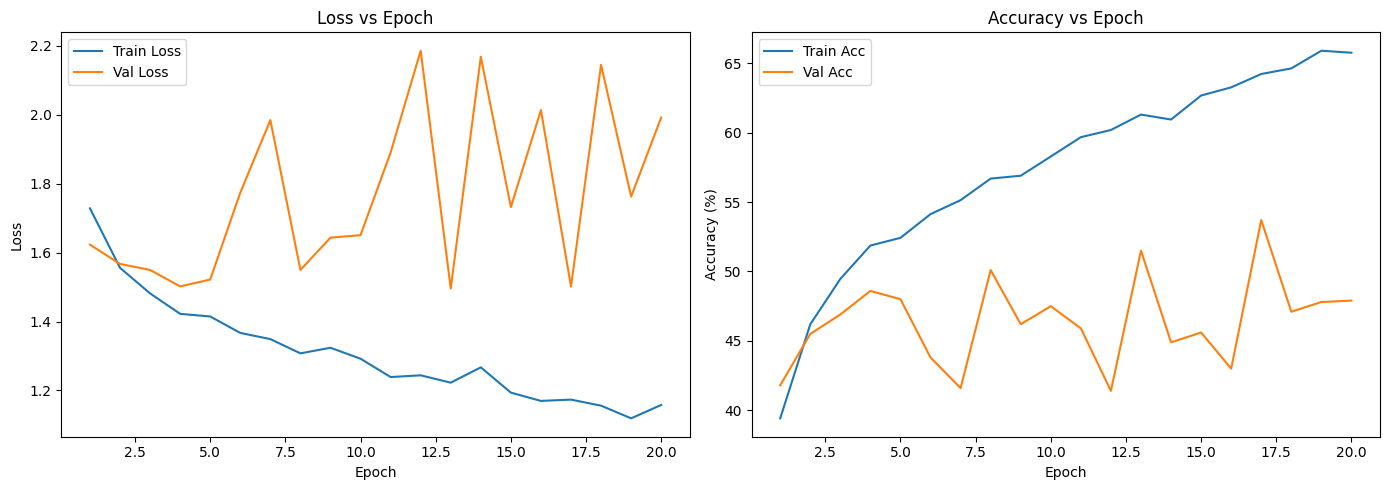

In [6]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Acc')
plt.plot(epochs, val_acc_list, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
num_epochs_CNN = 20
batch_size_CNN = 128
learning_rate_CNN = 0.001
reg_CNN = 1e-4

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split train and val
num_train = 49000
num_val = 1000
train_set, val_set = torch.utils.data.random_split(train_val_dataset, [num_train, len(train_val_dataset)-num_train])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_CNN, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size_CNN, shuffle=False, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_CNN, shuffle=False, num_workers=4, pin_memory=True)


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

model_CNN = CNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate_CNN, weight_decay=reg_CNN)


In [9]:
train_loss_list_CNN = []
val_loss_list_CNN = []
train_acc_list_CNN = []
val_acc_list_CNN = []

for epoch in range(num_epochs_CNN):
    model_CNN.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model_CNN(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss_list_CNN.append(total_train_loss / len(train_loader))
    train_acc_list_CNN.append(100 * correct_train / total_train)

    # Validation
    model_CNN.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model_CNN(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_list_CNN.append(total_val_loss / len(val_loader))
    val_acc_list_CNN.append(100 * correct_val / total_val)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss_list_CNN[-1]:.4f}, Train Acc: {train_acc_list_CNN[-1]:.2f}%, "
          f"Val Loss: {val_loss_list_CNN[-1]:.4f}, Val Acc: {val_acc_list_CNN[-1]:.2f}%")

Epoch [1/20], Train Loss: 1.6477, Train Acc: 41.37%, Val Loss: 1.3199, Val Acc: 53.40%
Epoch [2/20], Train Loss: 1.3563, Train Acc: 51.53%, Val Loss: 1.1927, Val Acc: 58.30%
Epoch [3/20], Train Loss: 1.2566, Train Acc: 55.44%, Val Loss: 1.1286, Val Acc: 61.80%
Epoch [4/20], Train Loss: 1.1850, Train Acc: 58.16%, Val Loss: 1.0872, Val Acc: 61.20%
Epoch [5/20], Train Loss: 1.1422, Train Acc: 59.86%, Val Loss: 1.0729, Val Acc: 61.80%
Epoch [6/20], Train Loss: 1.1021, Train Acc: 61.32%, Val Loss: 1.0767, Val Acc: 60.60%
Epoch [7/20], Train Loss: 1.0710, Train Acc: 62.18%, Val Loss: 1.0496, Val Acc: 61.70%
Epoch [8/20], Train Loss: 1.0491, Train Acc: 63.46%, Val Loss: 0.9791, Val Acc: 64.90%
Epoch [9/20], Train Loss: 1.0288, Train Acc: 64.01%, Val Loss: 0.9415, Val Acc: 67.20%
Epoch [10/20], Train Loss: 1.0003, Train Acc: 65.08%, Val Loss: 0.9426, Val Acc: 67.90%
Epoch [11/20], Train Loss: 0.9900, Train Acc: 65.62%, Val Loss: 0.9701, Val Acc: 67.30%
Epoch [12/20], Train Loss: 0.9783, Train 

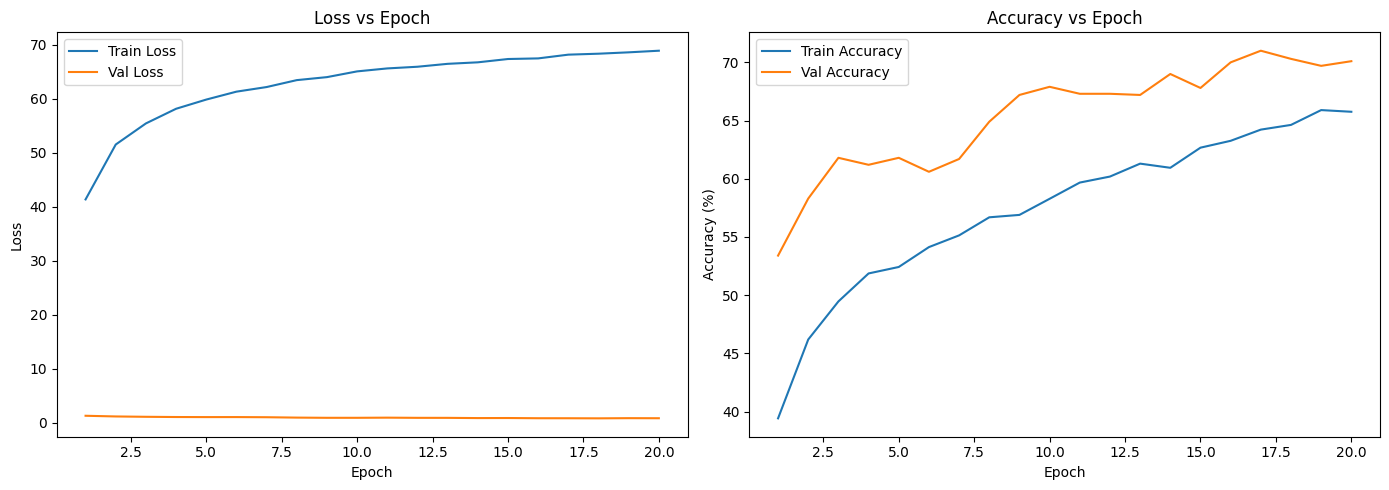

In [10]:
num_epochs_CNN = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(num_epochs_CNN, train_acc_list_CNN, label='Train Loss')
plt.plot(num_epochs_CNN, val_loss_list_CNN, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(num_epochs_CNN, train_acc_list, label='Train Accuracy')
plt.plot(num_epochs_CNN, val_acc_list_CNN, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
model_CNN.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_CNN(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 73.53%


In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 45.39%
